In [504]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

#Loading data

In [505]:
# download data from yahoo finance
df = yf.download("AMZN", start="2000-01-01", end="2023-12-31")

[*********************100%%**********************]  1 of 1 completed


In [506]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000


In [507]:
df.shape

(6037, 6)

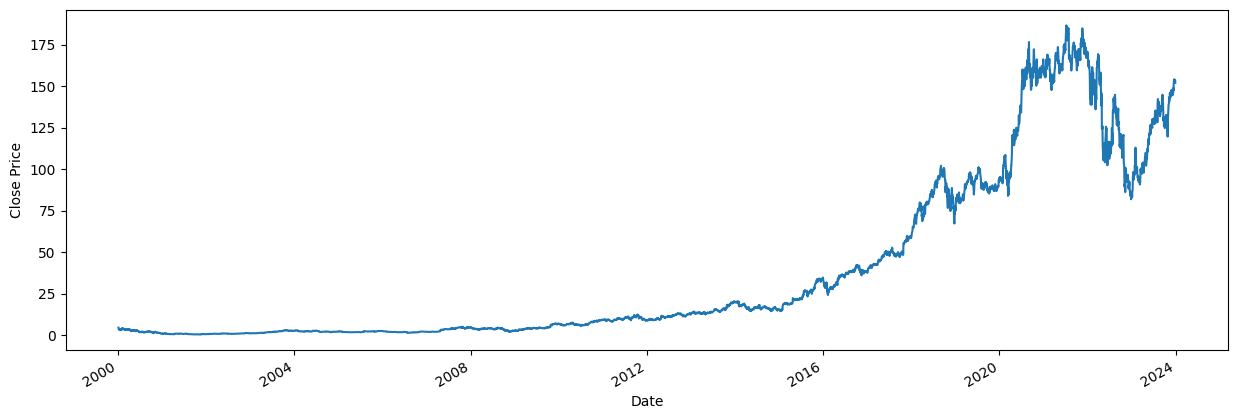

In [508]:
plt.figure(figsize=(15,5))
df['Close'].plot()
plt.ylabel('Close Price')
plt.show()

# Exponential smoothing data

In [509]:
alpha = 0.1

In [510]:
# df['Smooth'] = pd.Series(np.array([0 for i in range(df.shape[0])]))

In [511]:
# Initialize the 'Smooth' column with NaN values
df['Smooth'] = np.nan

df['Smooth']

Date
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
2000-01-07   NaN
              ..
2023-12-22   NaN
2023-12-26   NaN
2023-12-27   NaN
2023-12-28   NaN
2023-12-29   NaN
Name: Smooth, Length: 6037, dtype: float64

In [512]:
df.iloc[0, df.columns.get_loc('Smooth')] = df.iloc[0, df.columns.get_loc('Close')]

for i in range(1, df.shape[0]):
    df.iloc[i, df.columns.get_loc('Smooth')] = alpha * df.iloc[i-1, df.columns.get_loc('Close')] + (1 - alpha) * df.iloc[i-1, df.columns.get_loc('Smooth')]

In [513]:
df['Smooth'][:6]

Date
2000-01-03    4.468750
2000-01-04    4.468750
2000-01-05    4.431563
2000-01-06    4.337156
2000-01-07    4.231253
2000-01-10    4.155940
Name: Smooth, dtype: float64

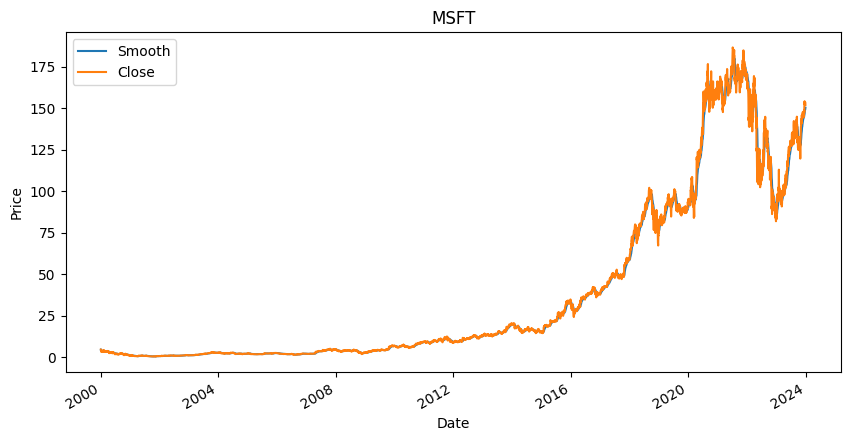

In [514]:
plt.figure(figsize=(10,5))
df.loc["2000-01-01":"2023-12-31", ['Smooth']].plot(ax=plt.gca())
df.loc["2000-01-01":"2023-12-31", ['Close']].plot(ax=plt.gca())
plt.title("MSFT")
plt.ylabel("Price")
plt.show()

In [515]:
df

,Open,High,Low,Close,Adj Close,Volume,Smooth
Date,,,,,,,
2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000,4.468750
2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000,4.468750
2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000,4.431563
2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000,4.337156
2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000,4.231253
...,...,...,...,...,...,...,...
2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100,148.600512
2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200,149.082460
2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700,149.515215


In [516]:
# Initialize the new columns with NaN values
df['Close_Trend'] = np.nan
df['Smooth_Trend'] = np.nan

# Compute the trends
for i in range(len(df) - 30):
    df.iloc[i, df.columns.get_loc('Close_Trend')] = np.sign(df.iloc[i + 30, df.columns.get_loc('Close')] - df.iloc[i, df.columns.get_loc('Close')])
    df.iloc[i, df.columns.get_loc('Smooth_Trend')] = np.sign(df.iloc[i + 30, df.columns.get_loc('Smooth')] - df.iloc[i, df.columns.get_loc('Smooth')])


In [517]:
# Filter out the last 30 rows
valid_range_df = df[:-30]

# Calculate the percentage of times Close_Trend equals Smooth_Trend
equal_trend_count = (valid_range_df['Close_Trend'] == valid_range_df['Smooth_Trend']).sum()
total_trend_count = len(valid_range_df)  # Only the valid range where the trends are computed

percentage_equal_trends = (equal_trend_count / total_trend_count) * 100

print(f"Percentage of times Close_Trend equals Smooth_Trend: {percentage_equal_trends:.2f}%")

Percentage of times Close_Trend equals Smooth_Trend: 82.15%


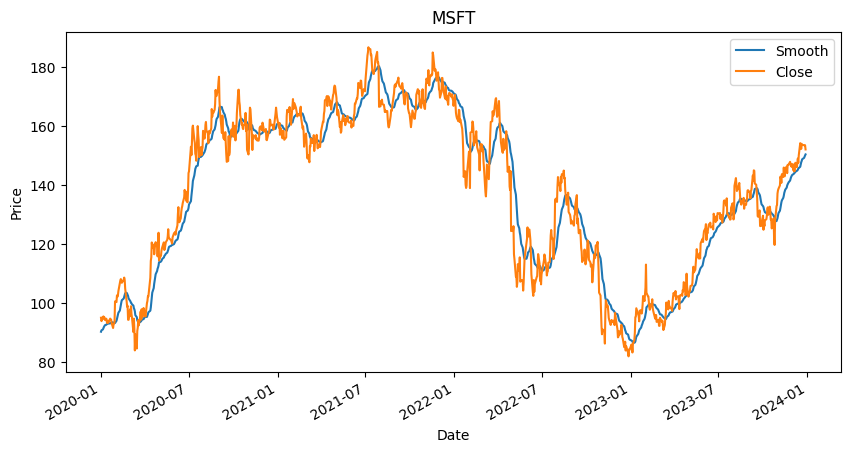

In [518]:
plt.figure(figsize=(10,5))
df.loc["2020-01-01":, ['Smooth']].plot(ax=plt.gca())
df.loc["2020-01-01":, ['Close']].plot(ax=plt.gca())
plt.title("MSFT")
plt.ylabel("Price")
plt.show()

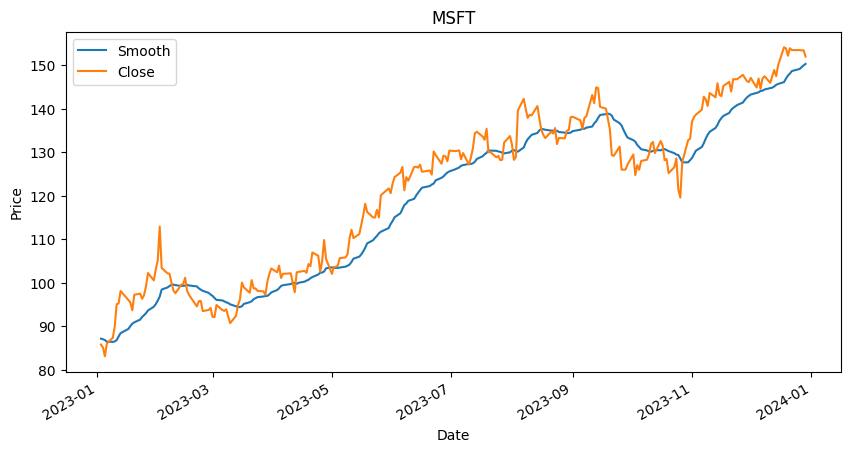

In [519]:
plt.figure(figsize=(10,5))
df.loc["2023-01-01":, ['Smooth']].plot(ax=plt.gca())
df.loc["2023-01-01":, ['Close']].plot(ax=plt.gca())
plt.title("MSFT")
plt.ylabel("Price")
plt.show()

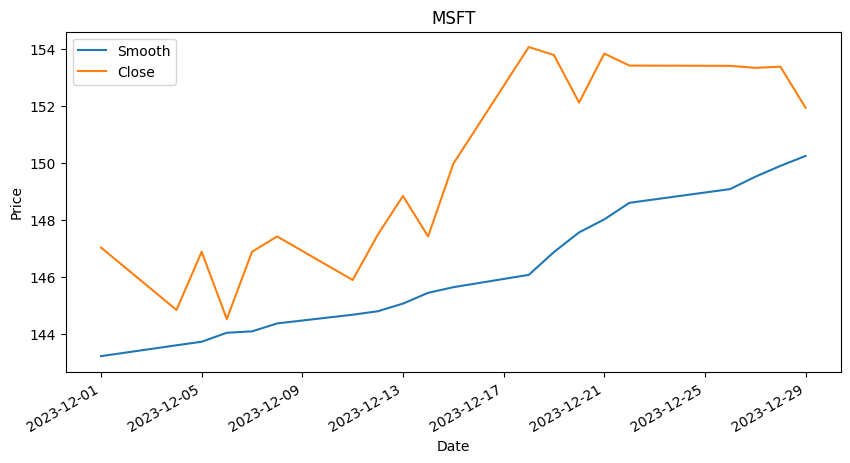

In [520]:
plt.figure(figsize=(10,5))
df.loc["2023-12-01":, ['Smooth']].plot(ax=plt.gca())
df.loc["2023-12-01":, ['Close']].plot(ax=plt.gca())
plt.title("MSFT")
plt.ylabel("Price")
plt.show()

In [521]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Smooth,Close_Trend,Smooth_Trend
Date,,,,,,,,,
2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000,4.468750,-1.0,-1.0
2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000,4.468750,-1.0,-1.0
2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000,4.431563,-1.0,-1.0
2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000,4.337156,-1.0,-1.0
2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000,4.231253,-1.0,-1.0


# Technical Indicators


RELATIVE STRENGTH INDEX (RSI)

It assesses the overbought and oversold conditions in stock prices by analyzing the degree of recent price changes. The RSI compares the average gains and losses of a stock over a set period, usually 14 trading days. The RSI value ranges from 0 to 100, with readings above 70 typically signaling that a stock is overbought, and readings below 30 indicating that it is oversold. In this study, a 27-day period is used to determine the initial RSI value. The RSI is calculated using the following formula:


$RSI = 100 - \dfrac{100}{1+RS}$


$RS = \dfrac{Average(gain)}{Average(loss)}$

RSI stands for relative strength index, and RS stands for relative strength.


In [522]:
def RSI(series):
    delta = series.diff()
    up = delta.clip(lower = 0)
    down = -1.0*delta.clip(upper = 0)

    ema_up = up.ewm(com = 26, adjust = False).mean()
    ema_down = down.ewm(com = 26, adjust = False).mean()

    rs = ema_up / ema_down
    rsi = 100 - (100 / (1+rs))
    return rsi

In [523]:
df['RSI'] = RSI(df['Smooth'])

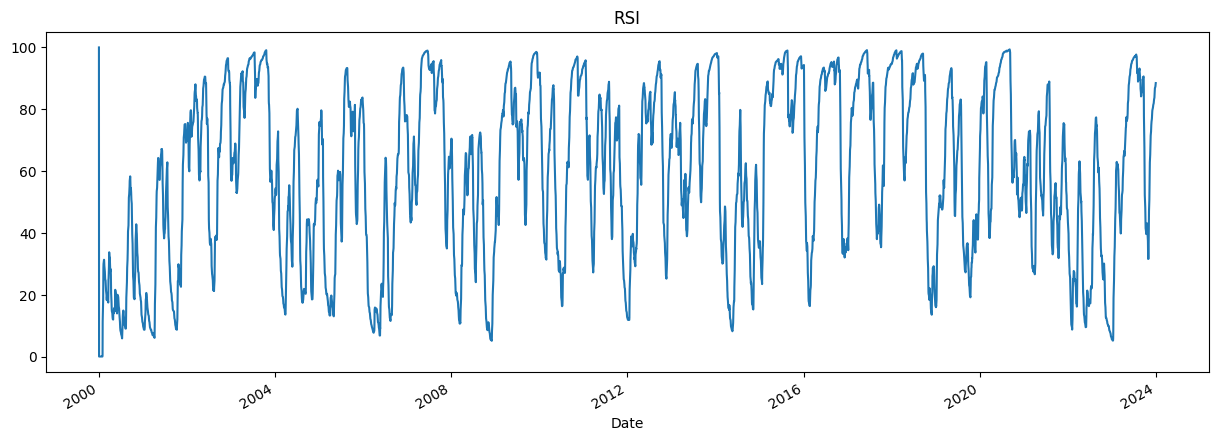

In [524]:
plt.figure(figsize=(15,5))
df['RSI'].plot()
plt.title("RSI")
plt.show()

MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)

The moving average convergence divergence (MACD) is a trend-following momentum indicator designed to help investors determine if the bearish or bullish momentum in prices is strengthening or weakening.

It is calculated by subtracting the 26-day exponential moving average (the longer moving average) from the 12-day exponential moving average (the shorter moving average) of a security’s prices. The resulting line is known as the MACD line. Additionally, the 9-day exponential moving average of the MACD line, referred to as the signal line, can serve as a trigger for buy and sell signals. A buy signal is indicated when the MACD line is above the signal line, while a sell signal is indicated when it is below the signal line.

The formula for calculating MACD is as follows:

$MACD = EMA_{12}(Price) - EMA_{26}(Price)$

$SL = EMA_9(MACD)$

MACD stands for moving average convergence divergence or MACD line and SL stands for the signal line.

$EMA_n$= n-day exponential moving average

In [525]:
def MACD(series):
    ema_12 = series.ewm(span = 12).mean()
    ema_26 = series.ewm(span = 26).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span = 9).mean()
    return macd, signal

In [526]:
df['MACD'] = MACD(df['Smooth'])[0] - MACD(df['Smooth'])[1]

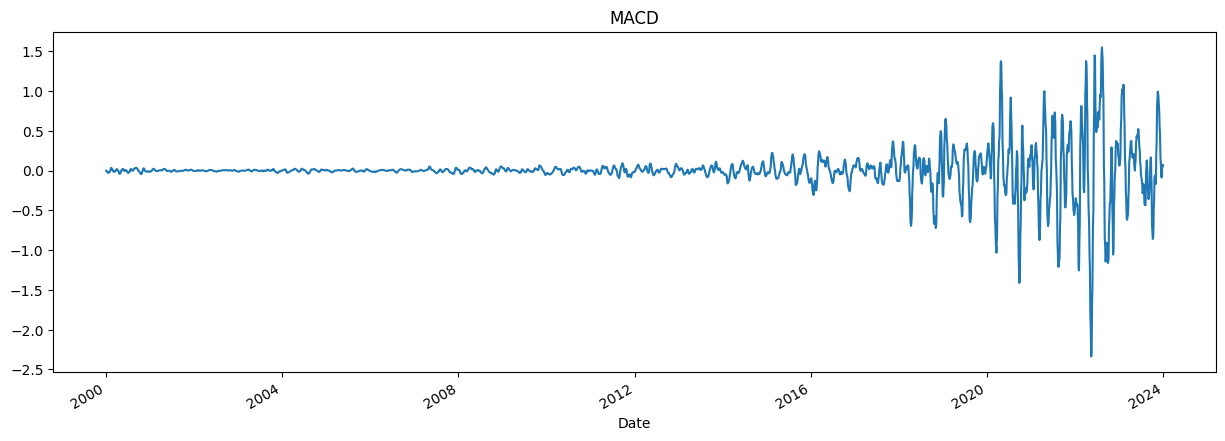

In [527]:
plt.figure(figsize=(15,5))
df['MACD'].plot(ax=plt.gca())
plt.title("MACD")
plt.show()

PRICE RATE OF CHANGE (ROC)

The price rate of change (ROC) is another momentum oscillator that calculates the percent change in price between the current price and the price from n periods ago. In other words, ROC measures the difference between the current price and the closing price n days ago. It oscillates between positive and negative values, fluctuating above and below the zero line. This oscillator can be used to identify overbought and oversold conditions, divergences, and zero-line crossovers.

We use a 21-day time frame to calculate the initial value of the ROC. The formula for calculating ROC is as follows:

$ROC = \dfrac{Price_t(smooth) - C_{t-21}(smooth}{C_{t-21}(smooth)} .100$

where,

ROC stands for price rate of change at time t;

$Price_t$ = closing price at time t;

$Price_{t−21}$ = closing price 21 periods ago

In [528]:
def ROC(series):
    return (series - series.shift(21))*100/series.shift(21)

In [529]:
df['ROC'] = ROC(df['Smooth'])

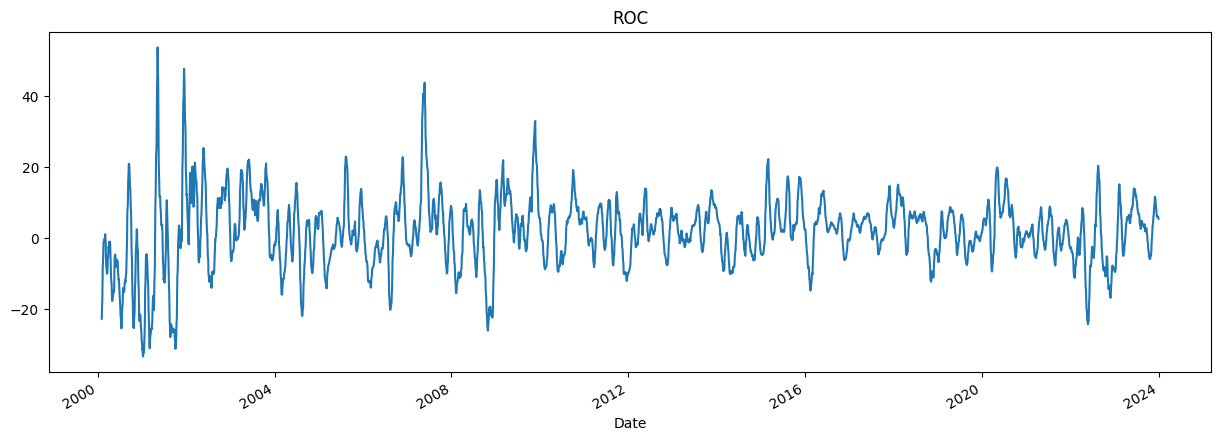

In [530]:
plt.figure(figsize=(15,5))
df['ROC'].plot()
plt.title("ROC")
plt.show()

STOCHASTIC OSCILLATOR (%K)


The stochastic oscillator, often denoted by the symbol %K, is a momentum oscillator developed by George Lane. It identifies the position of a stock’s closing price relative to the high and low range of the stock’s price over a given period, typically 14 trading days. The stochastic oscillator ranges from 0 to 100, with readings above 80 generally indicating overbought conditions and readings below 20 indicating oversold conditions. We use a 14-day time frame for %K. The formula for calculating the stochastic oscillator is as follows:

$\% K = \dfrac{Price_t - L_{14}}{H_{14} - L_{14}} \times 100$

where,

Price_t = the current closing price.

L14 = lowest price over the past 14 days H14 = highest price in the last 14 days

In [531]:
def STO_OS(low, high, smooth):
    low_14 = low.rolling(14).min()
    high_14 = high.rolling(14).max()
    return (smooth - low_14)*100/(high_14 - low_14)

In [532]:
df['%K'] = STO_OS(df['Low'], df['High'], df['Smooth'])

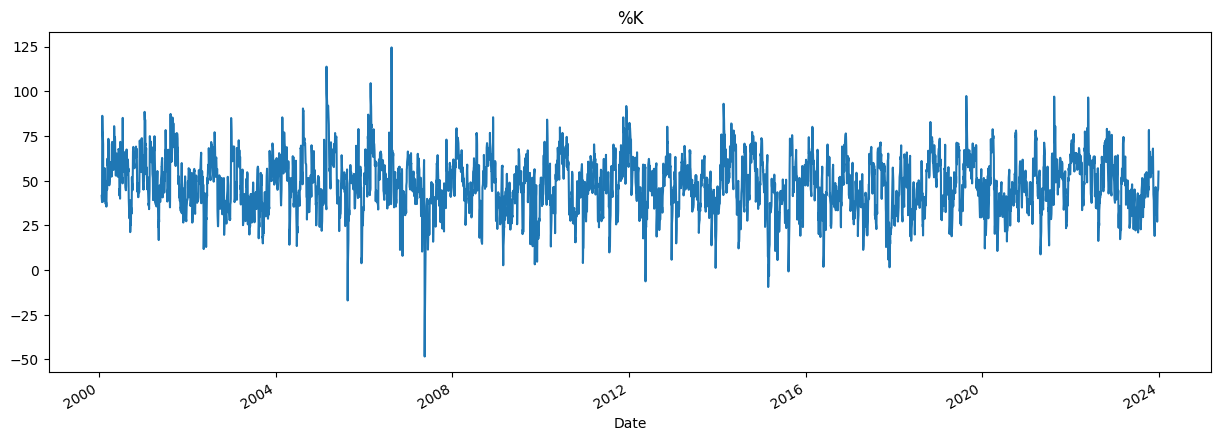

In [533]:
plt.figure(figsize=(15,5))
df['%K'].plot()
plt.title("%K")
plt.show()

WILLIAMS PERCENTAGE RANGE (WILLIAM %R)


The Williams Percentage Range, commonly known as Williams %R, is a popular indicator developed by Larry Williams. This indicator, often denoted by the symbol %R, measures overbought and oversold levels and operates inversely to %K. While %K ranges between 0 and 100, %R ranges between 0 and -100. A Williams %R below -80 signals a buy, while a Williams %R above -20 signals a sell. We also use a 14-day time frame for %R. The formula for calculating Williams %R is:

$\% R = \dfrac{H_{14} - Price_t}{H_{14} - L_{14}} \times -100$

where,

Price_t = the current closing price

L14 = lowest price over the past 14 days H14 = highest price in the last 14 days


In [534]:
def WILLIAM(low, high, smooth):
    low_14 = low.rolling(14).min()
    high_14 = high.rolling(14).max()
    return (high_14 - smooth)*-100/(high_14 - low_14)

In [535]:
df['%R'] = WILLIAM(df['Low'], df['High'], df['Smooth'])

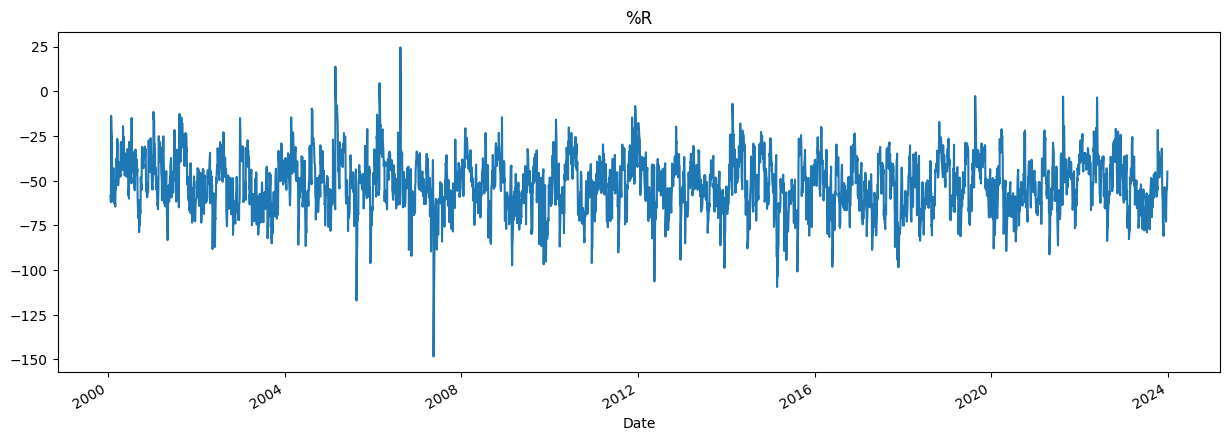

In [536]:
plt.figure(figsize=(15,5))
df['%R'].plot()
plt.title("%R")
plt.show()

COMMODITY CHANNEL INDEX (CCI)

The Commodity Channel Index (CCI), developed by Donald Lambert, is a valuable oscillator for assessing the direction and strength of a stock price trend. It's also employed to identify overbought and oversold conditions in stock prices. The CCI is calculated by finding the difference between the mean price of a stock and the average of the means, then comparing this difference to the average difference over a period of time, typically 20 days. The CCI is commonly scaled by an inverse factor of 0.015. The formula used to calculate the CCI is as follows:

$CCI = \dfrac{TypicalPrice - MovingAverage_{20}}{0.015 \times  Mean Deviation_20}$

where,
Typical price = average of low, high and close prices: $\sum_{i = 1}^{20}(H+L+Price(smooth))/3$

In [537]:
def CCI(high, low, smooth):
    typical_price = (high + low + smooth) / 3
    rolling_mean = typical_price.rolling(window=20).mean()
    rolling_std = typical_price.rolling(window=20).std()
    return (typical_price - rolling_mean) / (0.015 * rolling_std)


In [538]:
df['CCI'] = CCI(df['High'], df['Low'], df['Smooth'])

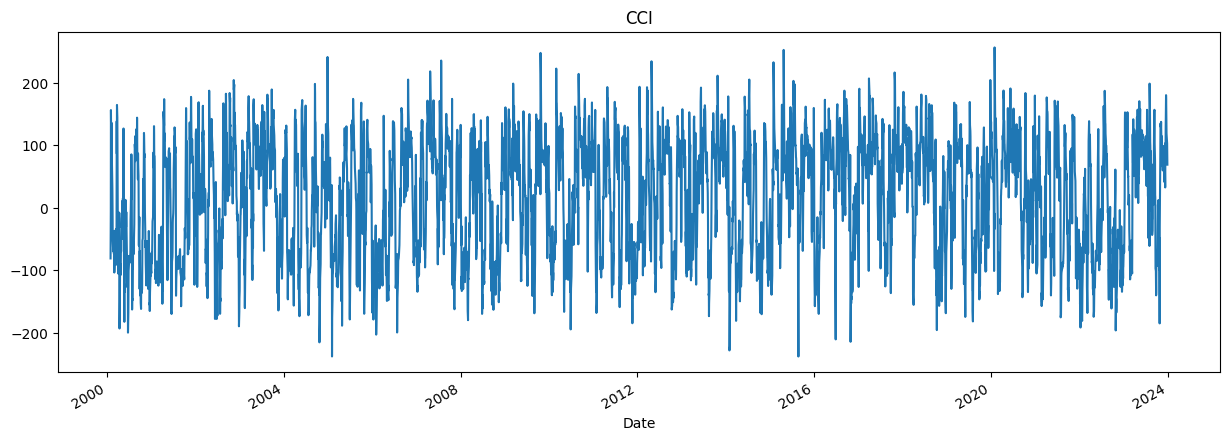

In [539]:
plt.figure(figsize=(15,5))
df['CCI'].plot()
plt.title("CCI")
plt.show()

DISPARITY INDEX (DIX)

The Disparity Index (DIX), developed by Steve Nison, is a widely used indicator in technical analysis. It's a momentum indicator that compares a stock’s current price with its moving average (MA) over a specific time period. A DIX below 0 indicates that the stock’s current price is below the n-day MA, while a DIX above 0 indicates that the stock’s current price is above the n-day MA. If the DIX equals 0, it indicates that the stock’s current price is equal to the n-day MA. In this paper, a 14-day MA is used. The formula for calculating the DIX with a 14-day MA is as follows:

$DIX = \dfrac{Price_t - MA_{14}}{MA_{14} \times 100}$

where,

Price_t = current stock price.

MA14 = moving average over 14 days

In [540]:
def DIX(smooth):
    ma_14 = smooth.rolling(window=14).mean()
    return (smooth - ma_14)/(ma_14)

In [541]:
df['DIX'] = DIX(df['Smooth'])

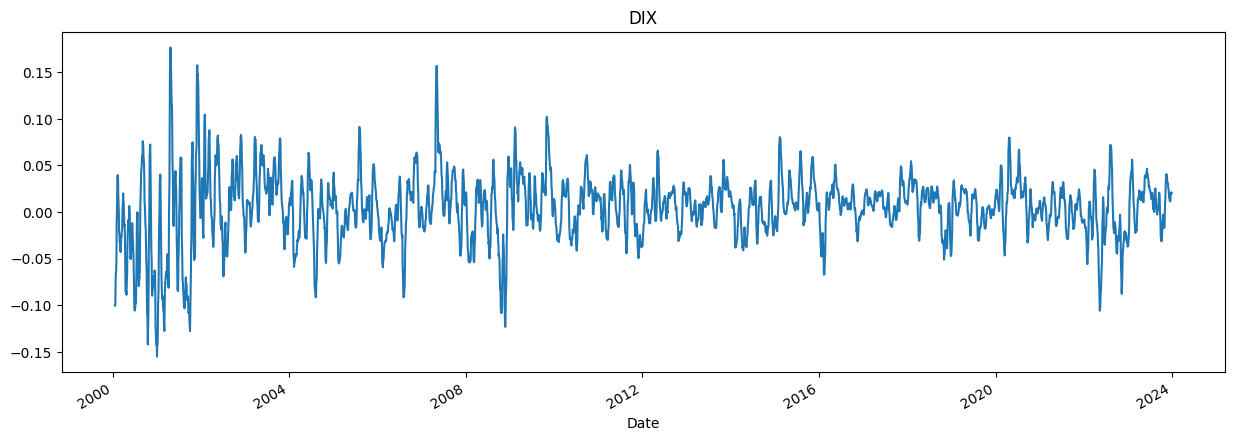

In [542]:
plt.figure(figsize=(15,5))
df['DIX'].plot()
plt.title("DIX")
plt.show()

# DATA LABELLING

In [543]:
df['Target_30_smooth'] = np.sign(df['Smooth'].shift(-30) - df['Smooth'])

In [544]:
df.dropna(axis=0, inplace = True)

In [545]:
df

,Open,High,Low,Close,Adj Close,Volume,Smooth,Close_Trend,Smooth_Trend,RSI,MACD,ROC,%K,%R,CCI,DIX,Target_30_smooth
Date,,,,,,,,,,,,,,,,,
2000-02-02,3.396875,3.612500,3.387500,3.471875,3.471875,280518000,3.446344,-1.0,-1.0,1.691092e-12,-0.015405,-22.879015,70.221791,-29.778209,-4.264953,-0.052108,-1.0
2000-02-03,4.056250,4.296875,3.868750,4.209375,4.209375,875000000,3.448897,-1.0,-1.0,3.975864e-01,-0.012045,-22.821882,38.328882,-61.671118,156.404334,-0.042391,-1.0
2000-02-04,4.137500,4.137500,3.893750,3.928125,3.928125,220460000,3.524945,-1.0,-1.0,1.130543e+01,-0.004131,-20.458193,43.859630,-56.140370,135.818216,-0.014631,-1.0
2000-02-07,3.809375,3.843750,3.656250,3.750000,3.750000,202580000,3.565263,-1.0,-1.0,1.634906e+01,0.004256,-17.797223,46.791848,-53.208152,72.831802,0.001327,-1.0
2000-02-08,3.700000,4.200000,3.671875,4.156250,4.156250,389456000,3.583737,-1.0,-1.0,1.855284e+01,0.011278,-15.303186,48.135390,-51.864610,114.056692,0.009688,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,142.020004,142.649994,139.839996,140.600006,140.600006,36235400,133.994076,1.0,1.0,6.091329e+01,0.735788,2.991956,62.526298,-37.473702,106.254435,0.031143,1.0
2023-11-10,140.460007,143.649994,139.910004,143.559998,143.559998,49287800,134.654669,1.0,1.0,6.283911e+01,0.821400,3.362383,64.445351,-35.554649,101.328527,0.033434,1.0
2023-11-13,142.080002,143.229996,140.669998,142.589996,142.589996,35680600,135.545202,1.0,1.0,6.523689e+01,0.893826,3.882045,67.965244,-32.034756,95.269679,0.036788,1.0


# CORRELATION AMONG FEATURES AND TARGET

In [546]:
df['Target'] = df['Target_30_smooth']

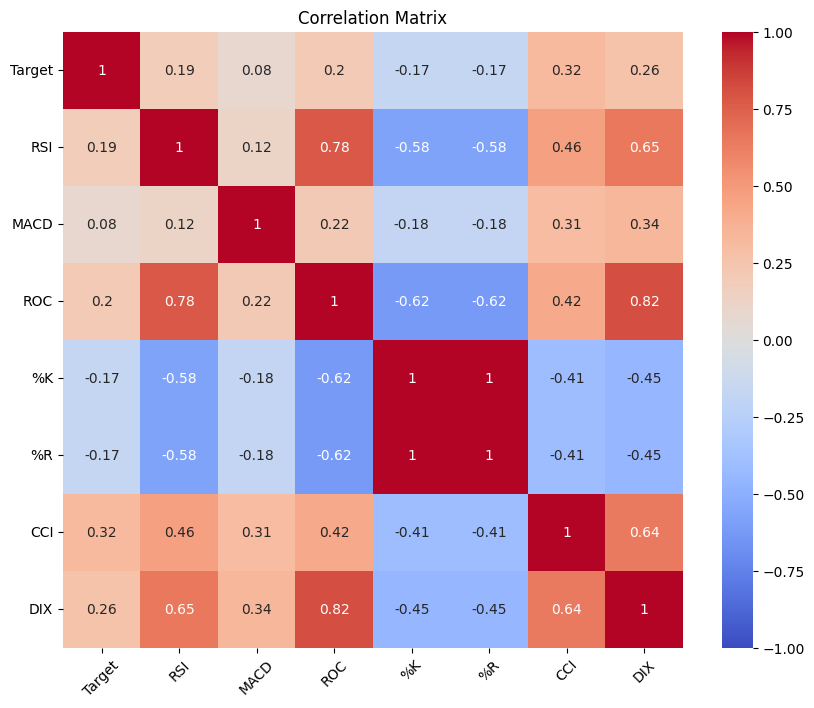

In [547]:
# Calculate the correlation matrix
correlation_matrix = df[['Target', 'RSI', 'MACD', 'ROC', '%K', '%R', 'CCI', 'DIX']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [283]:
# df = df.drop('ROC', axis = 1)

In [284]:
# df = df.drop('%K', axis = 1)

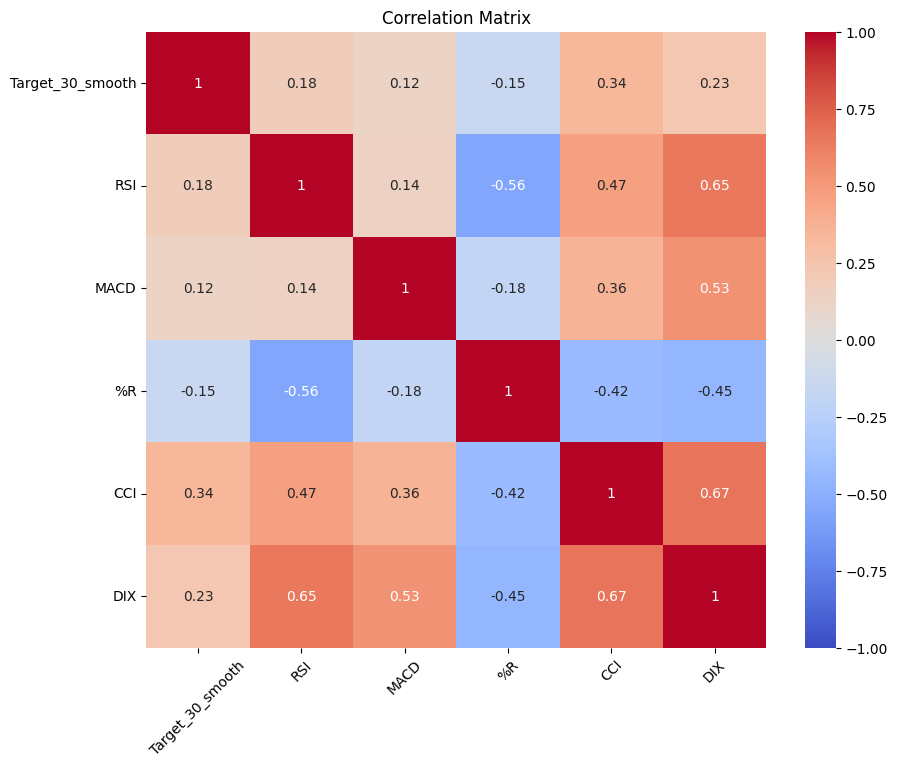

In [46]:
# Calculate the correlation matrix
correlation_matrix_ = df[['Target_30_smooth', 'RSI', 'MACD', '%R', 'CCI', 'DIX']].corr()

# Create a heatmap
# plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [47]:
df.loc[:, 'RSI':]

,RSI,MACD,%R,CCI,DIX,Target_30_smooth
Date,,,,,,
2000-02-02,2.007743,-0.258229,-51.821687,-66.199581,-0.042094,-1.0
2000-02-03,1.907716,-0.252317,-53.893853,-62.765059,-0.040892,-1.0
2000-02-04,1.881208,-0.232572,-54.458225,-19.805845,-0.036948,-1.0
2000-02-07,3.969295,-0.196353,-39.655231,-19.867002,-0.030284,-1.0
2000-02-08,5.911359,-0.151701,-32.534968,15.760503,-0.023607,-1.0
...,...,...,...,...,...,...
2023-11-09,79.014155,1.481735,-55.536805,131.766886,0.030535,1.0
2023-11-10,80.550216,1.610871,-60.039794,127.672206,0.032262,1.0
2023-11-13,82.408469,1.748247,-54.135442,120.118293,0.035599,1.0


# TRAIN TEST SPLIT CASE PREDICTING



In [ ]:
X = df.loc[:, 'RSI':'DIX']
y = df.loc[:, 'Target_30_smooth']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

PROPORTION OF UP AND DOWN DAYS IN TRAINING SET

In [ ]:
value_counts = pd.Series(y_train).value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_train)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_train)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

PROPORTION OF UP AND DOWN DAYS IN TESTING SET

In [ ]:
value_counts = pd.Series(y_test).value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_test)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_test)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

In [ ]:
grid_rf = {
'n_estimators': [75, 100, 150, 200],
'max_depth': [2, 5, 7, 9, None],
'max_features': [2, 3, 4]
}

cv = KFold(n_splits=4, shuffle=False)
gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
gscv_fit = gscv.fit(X_train, y_train)
best_parameters = gscv_fit.best_params_
print("Hyperparameter: ", best_parameters)

model = RandomForestClassifier(**best_parameters, random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion_mat = confusion_matrix(y_test, y_pred)

In [ ]:
print("TARGET 30 DAYS")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

# 2 UNSHUFFLED TRAINING SET AND TEST SET CASE

In [ ]:
x_train = df.loc['1999-01-01':'2015-12-31', 'RSI':'DIX']
y_train = df.loc['1999-01-01':'2015-12-31', 'Target_30_smooth']

PROPORTION OF UP AND DOWN DAYS IN TRAINING SET

In [ ]:
value_counts = y_train.value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_train)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_train)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

In [ ]:
x_train

In [ ]:
grid_rf = {
'n_estimators': [75, 100, 150, 200],
'max_depth': [2, 5, 7, 9, None],
'max_features': [2, 3, 4]
}

cv = KFold(n_splits=4, shuffle=False)
gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
gscv_fit = gscv.fit(x_train, y_train)
best_parameters = gscv_fit.best_params_
print("Hyperparameter: ", best_parameters)

model = RandomForestClassifier(**best_parameters, random_state = 42)
model.fit(x_train, y_train)

# MODEL TESTING FROM 2019-05-31


In [ ]:
y_pred = model.predict(df.loc['2019-05-31':, 'RSI':'DIX'].values)
y_test = df.loc['2019-05-31':, 'Target_30_smooth'].values

PROPORTION OF UP AND DOWN DAYS IN TESTING SET

In [ ]:
value_counts = pd.Series(y_test).value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_test)
proportion_minus_1 = value_counts.get(-1, 0) / len(y_test)

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
confusion_mat = confusion_matrix(y_test, y_pred)

In [ ]:
print("TARGET 30 DAYS FROM 2020-06-01")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

# K-FOLDS CROSS-VALIDATION

In [ ]:
X = df.loc[:, 'RSI':'DIX'].values
y = df.loc[:, 'Target_30_smooth'].values

In [ ]:
folds = 5

In [ ]:
kfold = KFold(n_splits=folds, shuffle=False)
models = []
scores = []

In [ ]:
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    value_counts_train = pd.Series(y_train).value_counts()

    # Get proportion of 1s and -1s in training set
    proportion_1_train = value_counts_train.get(1, 0) / len(y_train)
    proportion_minus_1_train = value_counts_train.get(-1, 0) / len(y_train)

    print("Proportion of 1s of Target_30_smooth in training set:", proportion_1_train)
    print("Proportion of -1s of Target_30_smooth in training set:", proportion_minus_1_train)

    value_counts_test = pd.Series(y_test).value_counts()

    # Get proportion of 1s and -1s in testing set
    proportion_1_test = value_counts_test.get(1, 0) / len(y_test)
    proportion_minus_1_test = value_counts_test.get(-1, 0) / len(y_test)

    print("Proportion of 1s of Target_30_smooth in testing set:", proportion_1_test)
    print("Proportion of -1s of Target_30_smooth in testing set:", proportion_minus_1_test)

    grid_rf = {
    'n_estimators': [75, 100, 150, 200],
    'max_depth': [2, 5, 7, 9, None],
    'max_features': [2, 3, 4]
    }

    cv = KFold(n_splits=4, shuffle=False)
    gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
    gscv_fit = gscv.fit(X_train, y_train)
    best_parameters = gscv_fit.best_params_
    print("Hyperparameter: ", best_parameters)

    model = RandomForestClassifier(**best_parameters, random_state = 42)
    model.fit(X_train, y_train)

    models.append(model)

    training_error = 1 - accuracy_score(y_train, model.predict(X_train))
    print("Training error:", training_error)

    y_pred = model.predict(X_test)

    score = model.score(X_test, y_test)
    scores.append(score)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    confusion_mat = confusion_matrix(y_test, y_pred)

    print("TARGET 30 DAYS")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(confusion_mat)


Proportion of 1s of Target_30_smooth in training set: 0.6347117794486216
Proportion of -1s of Target_30_smooth in training set: 0.36528822055137844
Proportion of 1s of Target_30_smooth in testing set: 0.44824707846410683
Proportion of -1s of Target_30_smooth in testing set: 0.5517529215358932
Hyperparameter:  {'max_depth': 2, 'max_features': 4, 'n_estimators': 150}
Training error: 0.29448621553884713
TARGET 30 DAYS
Accuracy: 0.5726210350584308
Precision: 0.5886341298830846
Recall: 0.5851103091360361
F1 Score: 0.5710717332624717
Confusion Matrix:
[[307 354]
 [158 379]]
Proportion of 1s of Target_30_smooth in training set: 0.6199624138651075
Proportion of -1s of Target_30_smooth in training set: 0.38003758613489247
Proportion of 1s of Target_30_smooth in testing set: 0.5071010860484545
Proportion of -1s of Target_30_smooth in testing set: 0.4928989139515455
Hyperparameter:  {'max_depth': 2, 'max_features': 4, 'n_estimators': 75}
Training error: 0.3157235330966799
TARGET 30 DAYS
Accuracy:

# FEATURE IMPORTANCE IN K-FOLDS CROSS-VALIDATION

In [ ]:
model_names = ['1st model', '2nd model', '3rd model', '4th model', '5th model']

feature_importances = []
for model in models:
    importance = model.feature_importances_
    feature_importances.append(importance)

num_features = len(x_train.columns)
bar_width = 0.12
index = np.arange(num_features)
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
# Plotting the feature importance
plt.figure(figsize=(12, 6))

for i, feature_importance in enumerate(feature_importances):
    sorted_indices = feature_importance.argsort()[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_features = x_train.columns[sorted_indices]

    plt.bar(index + i * bar_width, sorted_importance, bar_width, align='center', color=colors[i], label=model_names[i])

plt.xticks(index+bar_width*2, sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.legend()
plt.tight_layout()
plt.show()


# ROLLING CROSS-VALIDATION

In [ ]:
folds = 5

In [ ]:
tscv = TimeSeriesSplit(n_splits=folds)
models_ts = []
score_ts = []
train_ts = []

In [ ]:
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(len(X_train))

    value_counts_train = pd.Series(y_train).value_counts()

    # Get proportion of 1s and -1s in training set
    proportion_1_train = value_counts_train.get(1, 0) / len(y_train)
    proportion_minus_1_train = value_counts_train.get(-1, 0) / len(y_train)

    print("Proportion of 1s of Target_30_smooth in training set:", proportion_1_train)
    print("Proportion of -1s of Target_30_smooth in training set:", proportion_minus_1_train)

    value_counts_test = pd.Series(y_test).value_counts()

    # Get proportion of 1s and -1s in testing set
    proportion_1_test = value_counts_test.get(1, 0) / len(y_test)
    proportion_minus_1_test = value_counts_test.get(-1, 0) / len(y_test)

    print("Proportion of 1s of Target_30_smooth in testing set:", proportion_1_test)
    print("Proportion of -1s of Target_30_smooth in testing set:", proportion_minus_1_test)


    grid_rf = {
    'n_estimators': [75, 100, 150, 200],
    'max_depth': [2, 5, 7, 9, None],
    'max_features': [2, 3, 4]
    }

    cv = KFold(n_splits=4, shuffle=False)
    gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_rf, cv=cv, scoring='accuracy')
    gscv_fit = gscv.fit(X_train, y_train)
    best_parameters = gscv_fit.best_params_
    print("Hyperparameter: ", best_parameters)

    model = RandomForestClassifier(**best_parameters, random_state = 42)
    model.fit(X_train, y_train)

    models.append(model)

    training_error = 1 - accuracy_score(y_train, model.predict(X_train))
    print("Training error:", training_error)

    models_ts.append(model)

    training_error = 1 - accuracy_score(y_train, model.predict(X_train))
    train_ts.append(training_error)
    print("Training error:", training_error)

    y_pred = model.predict(X_test)

    score = model.score(X_test, y_test)
    score_ts.append(score)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    confusion_mat = confusion_matrix(y_test, y_pred)

    print("TARGET 30 DAYS")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(confusion_mat)


In [ ]:
model_names = ['1st roll', '2nd roll', '3rd roll', '4th roll', '5th roll']

feature_importances = []
for model in models_ts:
    importance = model.feature_importances_
    feature_importances.append(importance)

num_features = len(x_train.columns)
bar_width = 0.12
index = np.arange(num_features)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Plotting the feature importance
plt.figure(figsize=(12, 6))

for i, feature_importance in enumerate(feature_importances):
    sorted_indices = feature_importance.argsort()[::-1]
    sorted_importance = feature_importance[sorted_indices]
    sorted_features = x_train.columns[sorted_indices]

    plt.bar(index + i * bar_width, sorted_importance, bar_width, align='center', color=colors[i], label=model_names[i])

plt.xticks(index+bar_width*2, sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.legend()
plt.tight_layout()
plt.show()
